In [15]:
import os
import h5py
import numpy as np

In [16]:
tracks = []
for file in os.listdir("data/classical/"):
    if file.endswith(".h5"):
        h5f = h5py.File('data/classical/' + file, 'r')
        tracks.append(np.transpose(h5f['dataset_1'][:]))
h5f.close()

In [161]:
X_train = []
Y_train = []
for track in tracks:
    track[1:,0] = np.diff(track[:,0]) # absolute to relative timing
    track[:,0] = track[:,0]/np.max(track[:,0]) # normalize timing to [0,1]
    track[:,3] = track[:,3]/127.0 # normalize note to [0,1]
    track[:,4] = track[:,4]/127.0 # normalize velocity to [0,1]
    track[:,5] = track[:,5]/np.max(track[:,5]) # normalize duration to [0,1]
    for event_idx in range(10,track.shape[0]):
        X_train.append(track[event_idx-10:event_idx,[0,3,4,5]])
        Y_train.append(track[event_idx,[0,3,4,5]])

In [162]:
np.save('X_train',X_train)
np.save('Y_train',Y_train)

In [43]:
for track in tracks: 
    print np.max(track[:,2])
    #print np.max(np.diff(track[:,0]))

21.0
2.0
3.0
7.0
7.0
7.0
7.0
126.0
24.0
23.0
59.0
58.0
74.0
108.0
2.0
2.0
2.0
24.0


In [1]:
import numpy as np
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM, TimeDistributed

Using TensorFlow backend.


In [2]:
X_train = np.load('X_train.npy')
Y_train = np.load('Y_train.npy')

data = np.vstack((seq for seq in X_train))

mean = data.mean(axis=0)
std = data.std(axis=0)

In [3]:
mean, std

(array([ 0.1462929 ,  0.50185493,  0.6907397 ,  0.12843124]),
 array([ 0.22144724,  0.08731423,  0.24911765,  0.13013665]))

In [4]:
for batch in range(len(X_train)):
    X_train[batch] = (X_train[batch] - mean)/std
X_train = np.array(X_train)
Y_train = (Y_train - mean)/std

In [5]:
X_train.shape, Y_train.shape

((16348, 10, 4), (16348, 4))

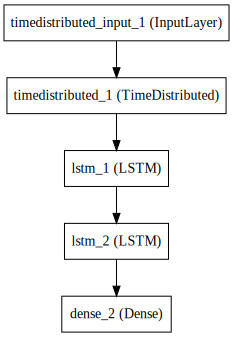

In [8]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [6]:
data_dim = 4
timesteps = 10
num_labels = 4

model = Sequential()
model.add(TimeDistributed(Dense(42, activation='relu'), input_shape=(timesteps, data_dim)))
model.add(LSTM(42, return_sequences=True))
model.add(LSTM(42, return_sequences=False))
model.add(Dense(num_labels, activation='sigmoid'))

model.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['mean_absolute_percentage_error'])

In [177]:
model.fit(X_train, Y_train, batch_size=50, nb_epoch=10)

Epoch 1/10
16348/16348 [==============================] - 30s - loss: 0.5973 - mean_absolute_percentage_error: 81.2957    
Epoch 2/10
16348/16348 [==============================] - 30s - loss: 0.5972 - mean_absolute_percentage_error: 81.8684    
Epoch 3/10
16348/16348 [==============================] - 29s - loss: 0.5976 - mean_absolute_percentage_error: 81.5091    
Epoch 4/10
16348/16348 [==============================] - 29s - loss: 0.5972 - mean_absolute_percentage_error: 81.3078    
Epoch 5/10
16348/16348 [==============================] - 29s - loss: 0.5970 - mean_absolute_percentage_error: 81.4826    
Epoch 6/10
16348/16348 [==============================] - 30s - loss: 0.5971 - mean_absolute_percentage_error: 81.6497    
Epoch 7/10
16348/16348 [==============================] - 29s - loss: 0.5972 - mean_absolute_percentage_error: 81.3353    
Epoch 8/10
16348/16348 [==============================] - 29s - loss: 0.5971 - mean_absolute_percentage_error: 82.1506    
Epoch 9/10
16348

In [292]:
def generate_sample(font, BPM):
    import midi, midi2vec2midi
    from scipy.stats import threshold
    num_events = 100 # directly proportional to sample duration
    max_relative_timing = 250 # max spacing between events
    max_note_duration = 150
    starting_seq = X_train[np.random.randint(0,X_train.shape[0])]
    for event_idx in range(num_events):
        if (event_idx+1)%1000 == 0:
            print "On sample: " + str(event_idx+1)
        sample = X_train[np.random.randint(0,X_train.shape[0])]
        prediction = model.predict(np.array([sample]))
        #print prediction*np.array([max_relative_timing, 127, 127, max_note_duration])
        starting_seq = np.vstack((starting_seq, sample[5:10]))
        starting_seq = np.vstack((starting_seq, (prediction - mean)/std))
    starting_seq = threshold(starting_seq*std + mean, threshmax=1, newval=1)
    song = np.zeros((starting_seq.shape[0], 66)) - 1
    song[:,0] = np.array([np.sum(starting_seq[:,0][:idx+1]) for idx in range(starting_seq.shape[0])])
    song[:,0] = song[:,0]*max_relative_timing
    song[:,1] = BPM
    song[:,2] = font
    song[:,3] = starting_seq[:,1]*90.
    song[:,4] = starting_seq[:,2]*127.
    song[:,5] = starting_seq[:,3]*max_note_duration
    song = np.round(song)
    pattern = midi2vec2midi.vector_to_midi(song.T)
    midi.write_midifile('sample.mid', pattern)
    return song

In [293]:
song = generate_sample(55, 30)

In [209]:
#model.load_weights('weights.h5', by_name=False) # loads the weights of the model from a HDF5 file
model.save_weights('weights.h5') # saves the weights of the model as a HDF5 file.

model.summary() # prints a summary representation of your model.
model.get_config() # returns a dictionary containing the configuration of the model. 

#The model can be reinstantiated from its config via:

config = model.get_config()
#model = Sequential.from_config(config)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
timedistributed_1 (TimeDistribute(None, 10, 42)        210         timedistributed_input_1[0][0]    
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 10, 42)        14280       timedistributed_1[0][0]          
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, 42)            14280       lstm_1[0][0]                     
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 4)             172         lstm_2[0][0]                     
Total params: 28942
_______________________________________________________________________